# Dask Tutorial - I need to learn this somehow...

Link: https://examples.dask.org/

## Dask Arrays

https://examples.dask.org/array.html

In [1]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

/home/lukasro/Documents/TIPMIP/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40833 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://172.16.46.74:40833/status,
Dashboard: http://172.16.46.74:40833/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://172.16.46.74/18937/1,Workers: 0
Dashboard: http://172.16.46.74:40833/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: inproc://172.16.46.74/18937/4,Total threads: 4
Dashboard: http://172.16.46.74:33653/status,Memory: 1.86 GiB
Nanny: None,


In [2]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
x

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [3]:
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z.compute()

array([0.99684424, 1.00203985, 1.00138954, ..., 1.00415983, 1.00033856,
       1.00724398])

### Persist Data in Memory

Keeps data in memory (RAM). Future computations are faster.

In [6]:
y = y.persist()

In [7]:
# with storing in memory
%time y[0, 0].compute()

CPU times: user 132 ms, sys: 18.1 ms, total: 150 ms
Wall time: 54.6 ms


np.float64(1.9145753648674473)

In [8]:
# with storing in memory
%time y.sum().compute()

CPU times: user 1.65 s, sys: 121 ms, total: 1.77 s
Wall time: 824 ms


np.float64(99993340.37695107)

## Dask DataFrames

https://examples.dask.org/dataframe.html

In [1]:
from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=2, memory_limit="1GB")
client


/home/lukasro/Documents/TIPMIP/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33371 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33371/status,
Dashboard: http://127.0.0.1:33371/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36179,Workers: 0
Dashboard: http://127.0.0.1:33371/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39181,Total threads: 2
Dashboard: http://127.0.0.1:45551/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:36491,


2025-05-12 14:02:16,790 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0e25f76c0177d67fee2f1dd33e85811 initialized by task ('shuffle-transfer-f0e25f76c0177d67fee2f1dd33e85811', 3) executed on worker tcp://127.0.0.1:39181
2025-05-12 14:02:18,119 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0e25f76c0177d67fee2f1dd33e85811 deactivated due to stimulus 'task-finished-1747051338.1181452'
2025-05-12 14:02:28,912 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0e25f76c0177d67fee2f1dd33e85811 initialized by task ('shuffle-transfer-f0e25f76c0177d67fee2f1dd33e85811', 3) executed on worker tcp://127.0.0.1:39181
2025-05-12 14:02:29,895 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f0e25f76c0177d67fee2f1dd33e85811 deactivated due to stimulus 'task-finished-1747051349.8944392'
2025-05-12 14:04:33,625 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f127b5995f15eadfe9585e58b83f825e initialized by task ('shuffle-transfer-f127b5995f15ea

In [3]:
# make data for this tutorial
import dask

df = dask.datasets.timeseries()
df

,name,id,x,y
npartitions=30,,,,
2000-01-01,string,int64,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


Unlike Pandas, Dask DataFrames are **lazy**, meaning that data is only loaded when it is needed for a computation. No data is printed here, instead it is replaced by ellipses (...).

Some operations will automatically display the data.

In [7]:
# This sets some formatting parameters for displayed data.
import pandas as pd

pd.options.display.precision = 2
pd.options.display.max_rows = 10

# this displayes the first 3 rows of the dataframe - using data
df.head(3)

,name,id,x,y
timestamp,,,,
2000-01-01 00:00:00,Quinn,969,0.67,0.69
2000-01-01 00:00:01,Laura,1003,0.51,-0.11
2000-01-01 00:00:02,Ingrid,981,0.22,0.72


### Example use of Pandas Operations

In [8]:
df2 = df[df.y > 0]
df3 = df2.groupby("name").x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Dask Name: getitem, 8 expressions
Expr=(((Filter(frame=ArrowStringConversion(frame=Timeseries(24d6608)), predicate=ArrowStringConversion(frame=Timeseries(24d6608))['y'] > 0))[['name', 'x']]).std(ddof=1, numeric_only=False, split_out=None, observed=False))['x']

Notice that the data in df3 are still represented by ellipses. All of the operations in the previous cell are lazy operations. You can call `.compute()` when you want your result as a Pandas dataframe or series.

In [ ]:
computed_df = df3.compute()

computed_df

name
Bob         0.58
Dan         0.58
Edith       0.58
George      0.57
Hannah      0.58
            ... 
Patricia    0.58
Tim         0.58
Ursula      0.58
Victor      0.58
Xavier      0.58
Name: x, Length: 26, dtype: float64

### Another Example using Pandas

In [11]:
df4 = df.groupby("name").aggregate({"x": "sum", "y": "max"})
df4

,x,y
npartitions=1,,
,float64,float64
,...,...


In [12]:
df4.compute()

,x,y
name,,
Ingrid,-485.04,1.0
Alice,-201.52,1.0
Patricia,-42.52,1.0
Sarah,102.94,1.0
Kevin,-81.42,1.0
...,...,...
Tim,-485.63,1.0
Wendy,104.59,1.0
Dan,128.34,1.0


## Xarray with Dask Arrays

https://examples.dask.org/xarray.html

### Custom workflows and automatic parallelization

In [13]:
# start a new client
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

/home/lukasro/Documents/TIPMIP/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37365 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37365/status,
Dashboard: http://127.0.0.1:37365/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39411,Workers: 0
Dashboard: http://127.0.0.1:37365/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:46357,Total threads: 2
Dashboard: http://127.0.0.1:35855/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:32781,


In [1]:
# samle dataset
import xarray as xr
ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Quickly inspecting the Dataset above, we’ll note that this Dataset has three dimensions akin to axes in NumPy (lat, lon, and time), three coordinate variables akin to pandas.Index objects (also named lat, lon, and time), and one data variable (air). Xarray also holds Dataset specific metadata as attributes.



In [2]:
da = ds['air']
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float64, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [3]:
da_smooth = da.rolling(time=30).mean()#.persist()
da_smooth

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
dask.array<_trim, shape=(2920, 25, 53), dtype=float64, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Almost all of xarray’s built-in operations work on Dask arrays. If you want to use a function that isn’t wrapped by xarray, one option is to extract Dask arrays from xarray objects (.data) and use Dask directly.

Another option is to use xarray’s apply_ufunc() function, which can automate embarrassingly parallel “map” type operations where a function written for processing NumPy arrays should be repeatedly applied to xarray objects containing Dask arrays. It works similarly to dask.array.map_blocks() and dask.array.blockwise(), but without requiring an intermediate layer of abstraction.

Here we show an example using NumPy operations and a fast function from bottleneck, which we use to calculate Spearman’s rank-correlation coefficient:



In [7]:
import numpy as np
import xarray as xr
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])



In the examples above, we were working with an some air temperature data. For this example, we’ll calculate the spearman correlation using the raw air temperature data with the smoothed version that we also created (da_smooth). For this, we’ll also have to rechunk the data ahead of time.

In [8]:
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr

<xarray.DataArray 'air' (lat: 25, lon: 53)> Size: 11kB
dask.array<transpose, shape=(25, 53), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0

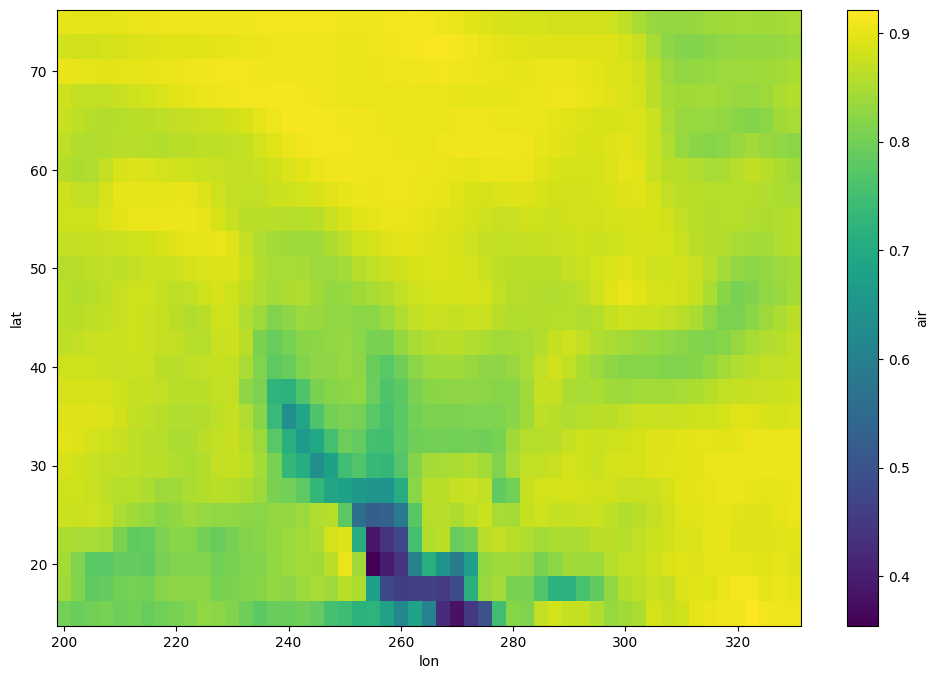

In [ ]:
corr.plot(figsize=(12, 8))